## 1. Imports and config

In [1]:
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tools.sm_exceptions import InterpolationWarning
from statsmodels.regression.rolling import RollingOLS

plt.rcParams['figure.figsize'] = (11, 6)
plt.rcParams['axes.grid'] = True

START = '2010-01-01'
END = None
GAL_PER_BBL = 42.0

## 2. Fetching prices

In [2]:
def fetch_clean_prices(start=START, end=END):
    """
    Pull WTI (CL=F, $/bbl), RBOB (RB=F, $/gal), Heating Oil (HO=F, $/gal).
    Returns a DF with columns: ['WTI', 'RBOB', 'HO'].
    """
    tickers = ['CL=F', 'RB=F', 'HO=F']
    raw = yf.download(tickers, start=start, end=end, auto_adjust=False, progress=False)

    if raw.empty:
        raise ValueError('Empty download from Yahoo. Check tickers or dates.')

    if isinstance(raw.columns, pd.MultiIndex):
        close = raw['Close'].copy()
    else:
        if 'Close' not in raw.columns:
            raise KeyError('Missing "Close" in Yahoo data')
        close = raw[['Close']].copy()

    df = close.rename(columns={'CL=F': 'WTI', 'RB=F': 'RBOB', 'HO=F': 'HO'}).dropna(how='all')
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    return df.dropna()

df = fetch_clean_prices()
print(df.tail())

Ticker            WTI      HO    RBOB
Date                                 
2025-09-22  62.639999  2.2923  1.9782
2025-09-23  63.410000  2.3280  1.9991
2025-09-24  64.989998  2.3772  2.0188
2025-09-25  64.980003  2.4265  2.0022
2025-09-26  65.720001  2.4167  2.0376


## 3. Crack spread (3:2:1)

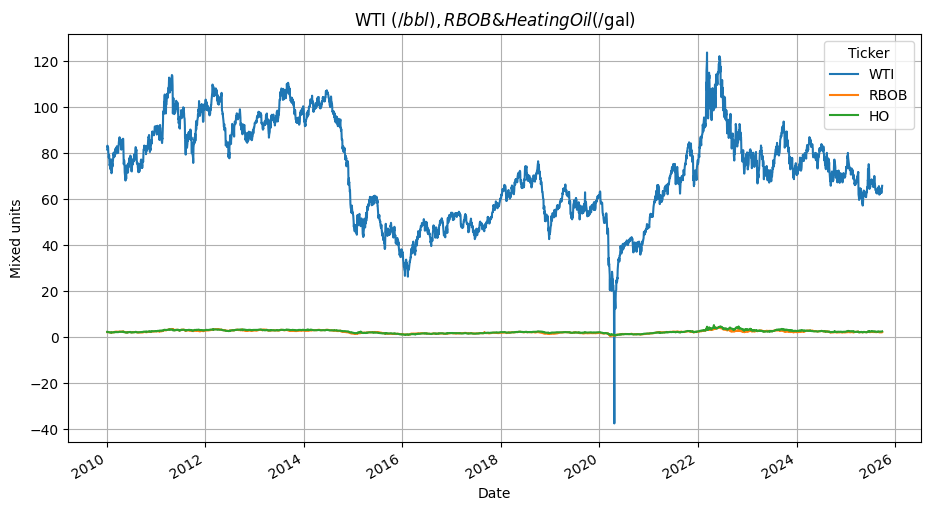

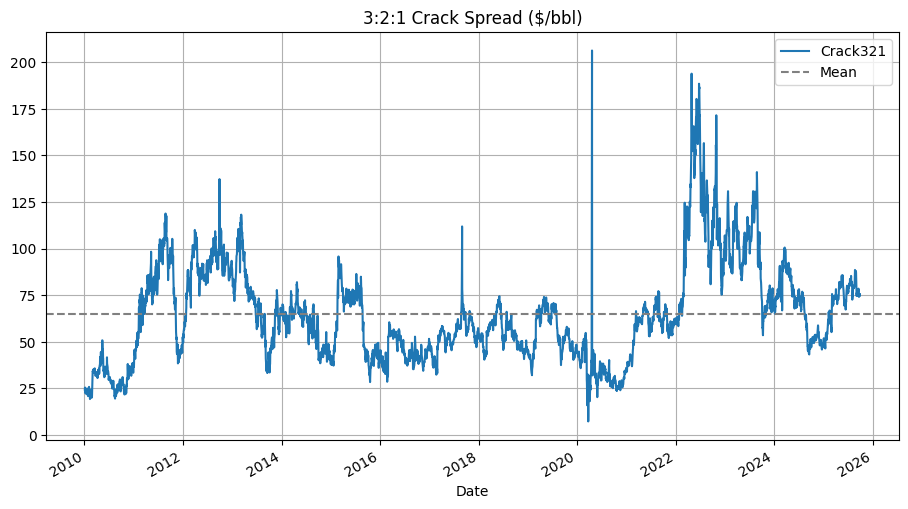

In [3]:
def crack_321(df):
    """
    3:2:1 crack in $/bbl:
    (2 * RBOB$/gal + 1 * HO$/gal)*42 - 3 * WTI$/bbl
    """
    df = df[['WTI', 'RBOB', 'HO']].dropna()
    products_per_bbl = (2.0 * df['RBOB'] + 1.0 * df['HO']) * GAL_PER_BBL
    crude_per_bbl = 3.0 * df['WTI']
    return (products_per_bbl - crude_per_bbl).rename('Crack321')

crack = crack_321(df)

ax = df[['WTI', 'RBOB', 'HO']].plot(title='WTI ($/bbl), RBOB & Heating Oil ($/gal)')
ax.set_ylabel('Mixed units'); plt.show()

ax = crack.plot(title='3:2:1 Crack Spread ($/bbl)')
ax.axhline(crack.mean(), ls='--', color='gray', label='Mean'); ax.legend(); plt.show()

## 4. Stationarity helpers (ADF/KPSS)

In [4]:
def kpss_pvalue(x, regression='c'):
    x = x.dropna()
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter('always')
        stat, p, lags, crit = kpss(x, regression=regression, nlags='auto')
        for m in w:
            if issubclass(m.category, InterpolationWarning):
                if stat >= max(crit.values()): return 0.01
                if stat <= min(crit.values()): return 0.10
        return p

def adf_kpss_summary(x):
    x = x.dropna()
    adf_p = adfuller(x, autolag='AIC')[1]
    kpss_p = kpss_pvalue(x, regression='c')
    return {'adf_p': float(adf_p), 'kpss_p': float(kpss_p) if not np.isnan(kpss_p) else np.nan}

print('Stationarity (levels):', adf_kpss_summary(crack))
print('Stationarity (returns):', adf_kpss_summary(crack.pct_change().dropna()))

Stationarity (levels): {'adf_p': 0.003045174224856212, 'kpss_p': 0.01}
Stationarity (returns): {'adf_p': 6.609971243185901e-22, 'kpss_p': 0.1}


## 5. Rolling alpha/beta vs WTI

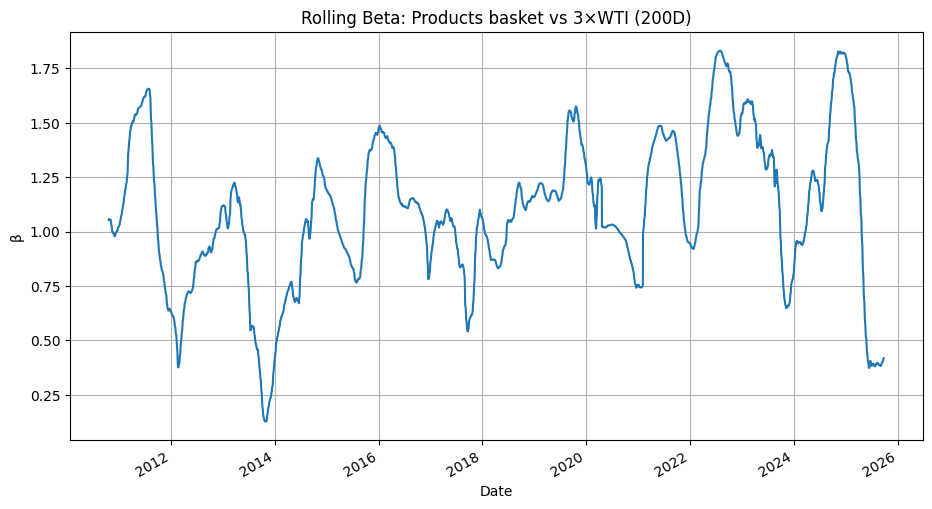

In [5]:
def rolling_ols_y_on_x(y, x, window=200):
    """
    Rolling OLS of y on [const, x], shifted 1 day to avoid look-ahead.
    Returns (alpha, beta, resid).
    """
    common = pd.concat([y, x], axis=1).dropna()
    y_, x_ = common.iloc[:, 0], common.iloc[:, 1]
    rols = RollingOLS(y_, sm.add_constant(x_), window=window).fit()
    beta = rols.params[x_.name].shift(1)
    alpha = rols.params['const'].shift(1)
    resid = (y_ - (alpha + beta * x_)).dropna()
    return alpha, beta, resid

products_per_bbl = (2.0 * df['RBOB'] + df['HO']) * GAL_PER_BBL
alpha_r, beta_r, resid_r = rolling_ols_y_on_x(products_per_bbl, 3.0 * df['WTI'], window=200)

ax = beta_r.dropna().plot(title='Rolling Beta: Products basket vs 3×WTI (200D)')
ax.set_ylabel('β'); plt.show()

## 6. Seasonality & volatility

Avg 3:2:1 crack by month ($/bbl):
 Date
1     54.53
2     59.02
3     72.92
4     72.88
5     73.48
6     71.73
7     70.65
8     71.36
9     59.86
10    58.49
11    56.16
12    53.08
Name: Crack321, dtype: float64


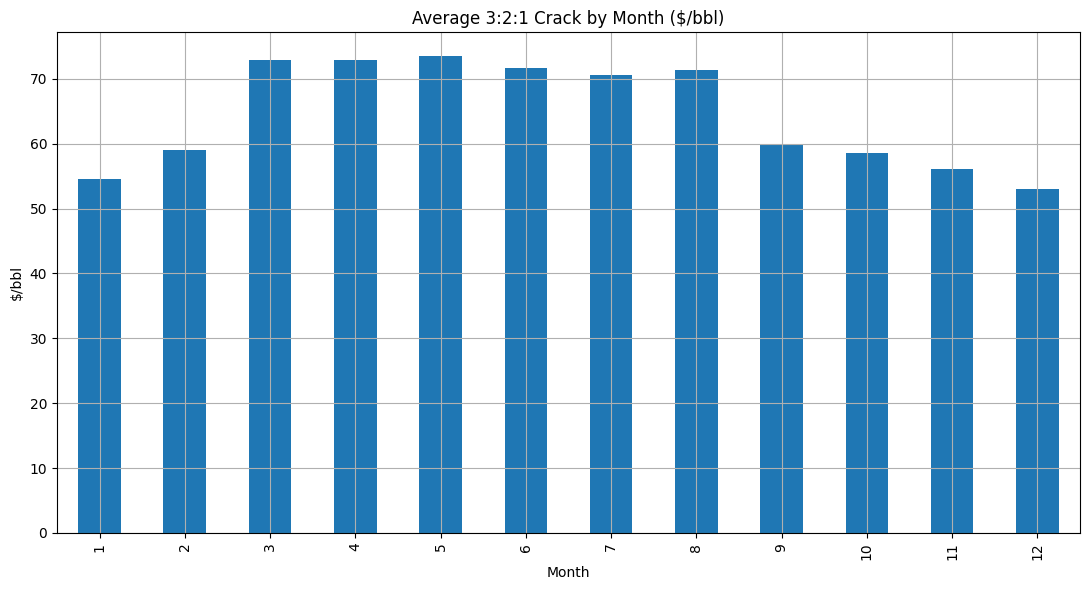

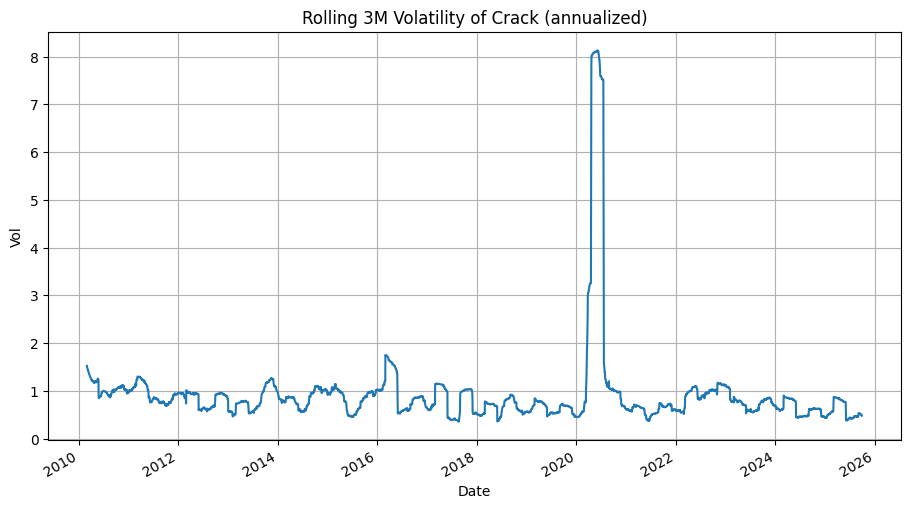

In [6]:
seasonal = crack.groupby(crack.index.month).mean().round(2)
print('Avg 3:2:1 crack by month ($/bbl):\n', seasonal)

ax = seasonal.plot(kind='bar', title='Average 3:2:1 Crack by Month ($/bbl)')
ax.set_xlabel('Month'); ax.set_ylabel('$/bbl'); plt.tight_layout(); plt.show()

roll_vol = crack.pct_change().rolling(63, min_periods=40).std() * np.sqrt(252)
ax = roll_vol.plot(title='Rolling 3M Volatility of Crack (annualized)')
ax.set_ylabel('Vol'); plt.show()

## 7. Simple (toy) z-score MR backtest on the crack spread

Backtest stats (toy): {'sharpe': 0.17414866592788011, 'total': 225.24389223098765, 'hit': 0.49178670710133937, 'maxdd': -254.40079684257503}


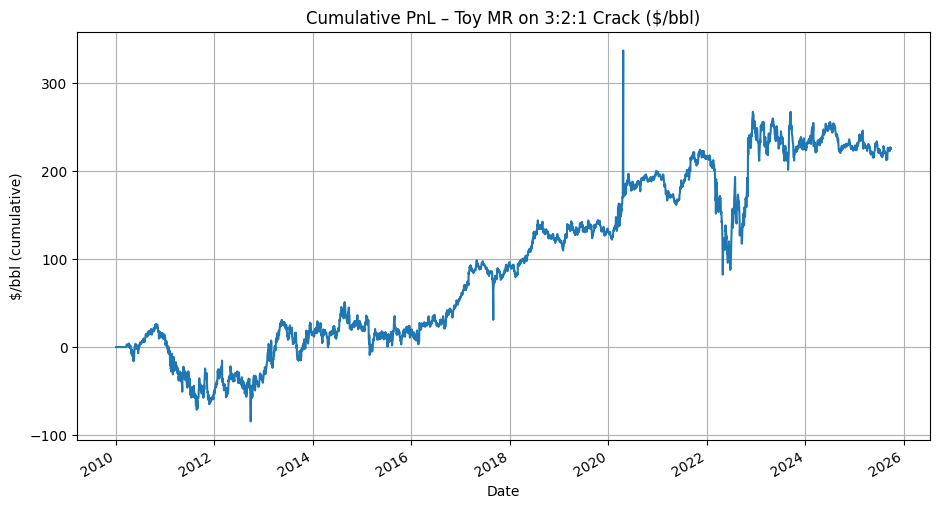

In [7]:
def strategy_stats(pnl):
    pnl = pnl.dropna()
    if pnl.empty or pnl.std() == 0:
        return {'sharpe': np.nan, 'total': 0.0, 'hit': np.nan, 'maxdd': np.nan}
    sharpe = pnl.mean() / pnl.std() * np.sqrt(252)
    cum = pnl.cumsum()
    dd = cum - cum.cummax()
    return {
        'sharpe': float(sharpe),
        'total': float(cum.iloc[-1]),
        'hit': float((pnl > 0).mean()),
        'maxdd': float(dd.min())
    }

def backtest_spread(s, lookback=63, entry=2.0, exit=0.0, tc_per_leg=0.01):
    """
    Toy MR on crack spread (in $/bbl). One 'position unit' = long/short crack.
    Transaction costs are charged per leg change; the crack has effectively 4 legs
    (2x RBOB, 1x HO, 3x WTI), but we keep it simple: cost scales with |Δposition|.
    """
    s = s.dropna()
    mu = s.rolling(lookback, min_periods=int(lookback*0.8)).mean().shift(1)
    sd = s.rolling(lookback, min_periods=int(lookback*0.8)).std().shift(1).replace(0, np.nan)
    z = (s - mu) / sd

    pos = pd.Series(0.0, index=s.index)
    z_lag = z.shift(1)

    pos[z_lag > entry] = -1.0 
    pos[z_lag < -entry] = 1.0  


    exit_mask = (pos.shift(1) != 0) & (z_lag.abs() <= exit)
    pos[exit_mask] = 0.0

    pos = pos.replace(0.0, np.nan).ffill().fillna(0.0)

    dS = s.diff().fillna(0.0)
    gross = pos.shift(1) * dS

    changes = (pos - pos.shift(1)).abs().fillna(0.0)
    costs = changes * (2 * tc_per_leg)
    pnl = (gross - costs).fillna(0.0)

    return pnl, pos, z, strategy_stats(pnl)

pnl, pos, z, stats = backtest_spread(crack, lookback=63, entry=2.0, exit=0.0, tc_per_leg=0.01)
print('Backtest stats (toy):', stats)

ax = pnl.cumsum().plot(title='Cumulative PnL – Toy MR on 3:2:1 Crack ($/bbl)')
ax.set_ylabel('$/bbl (cumulative)'); plt.show()